# <center> <img src="figs/LogoUFSCar.jpg" alt="Logo UFScar" width="110" align="left"/>  <br/> <center>Universidade Federal de São Carlos (UFSCar)<br/><font size="4"> Departamento de Computação, campus Sorocaba</center></font>
</p>

<font size="4"><center><b>Disciplina: Aprendizado de Máquina</b></center></font>
  
<font size="3"><center>Prof. Dr. Tiago A. Almeida</center></font>

## <center>Projeto Final</center>

**Aluno**: Eduardo Garcia do Nascimento

**RA/CPF**: 22008732800


---
### Carregamento dos dados

Nesta seção é feita a carga dos atributos em um dataframe só, ou seja, os três datasets são lidos e concatenados para que a redução de atributos leve em conta o que existe de melhor em todos eles.


In [1]:
# -*- coding: utf-8 -*-

# Caminho dos arquivos
FILES_DIRECTORY = "data"

import numpy as np 
import pandas as pd 
import os
from scripts import utils

if __name__ == '__main__':
    
                      
    # importa o arquivo e guarda em um dataframe do Pandas
    set1_dataset  = pd.read_csv(os.path.join(FILES_DIRECTORY, 'set1.csv'), sep=',', low_memory=False)
    set2_dataset  = pd.read_csv(os.path.join(FILES_DIRECTORY, 'set2.csv'), sep=',', low_memory=False) 
    set3_dataset  = pd.read_csv(os.path.join(FILES_DIRECTORY, 'set3.csv'), sep=',', low_memory=False)
    train_dataset = pd.read_csv(os.path.join(FILES_DIRECTORY, 'train.csv'), sep=',')
    test_dataset  = pd.read_csv(os.path.join(FILES_DIRECTORY, 'test.csv'), sep=',')
    
    # Renomeia colunas concatenando o setX antes de fazer o merge para identificá-las posteriormente
    cols = set1_dataset.columns
    for col in cols:
        set1_dataset = set1_dataset.rename(columns={col:'set1_'+col})
        
    cols = set2_dataset.columns
    for col in cols:
        set2_dataset = set2_dataset.rename(columns={col:'set2_'+col})
    
    cols = set3_dataset.columns
    for col in cols:
        set3_dataset = set3_dataset.rename(columns={col:'set3_'+col})

    # Concatena os datasets em somente um dataset único
    frames = [ set1_dataset, set2_dataset, set3_dataset ]
    input_dataset = pd.concat(frames, axis=1)
    input_dataset['classe'] = np.nan
    input_dataset.loc[train_dataset['Id'].values,'classe'] = train_dataset['Class'].values
    
    samples_mask = (input_dataset.classe!=-1)&(input_dataset.classe!=1)&(input_dataset.classe!=0)
    samples_df = input_dataset[samples_mask].drop('classe', axis=1)
    
    
    print('A base de dados inicial combinada tem %d amostras com %d atributos.' % (input_dataset.shape[0],
                                                                                 input_dataset.shape[1]))
    
        
   
    utils.beep(1, 400)

A base de dados inicial combinada tem 60842 amostras com 310 atributos.


---
### Pré-processamento e seleção de atributos

Nesta seção são feitas limpezas da base de dados como:

* Remoção de atributos sem variância;
* Tratamento de outliers e dados nulos;
* Seleção dos atributos que terão maior valor para o algoritmo de classificação.

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif

X_df = input_dataset.loc[(input_dataset['classe'] == -1) | (input_dataset['classe'] == 1)]

print(X_df.shape)
print('Separando a base em treino e teste')
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X_df.drop('classe', axis=1), 
                                                    X_df[['classe']], 
                                                    test_size=0.2, 
                                                    stratify=X_df[['classe']],
                                                    random_state=0, 
                                                    )

# Remove os atributos que são constantes e não oferecem nenhum valor aos algoritmos de classificação
variance_mask = VarianceThreshold().fit(X_train_df).get_support()
X_train_df = X_train_df.iloc[:,variance_mask]
X_test_df = X_test_df.iloc[:,variance_mask]
samples_df = samples_df.iloc[:,variance_mask]
variance_mask = np.append(variance_mask,True)
input_dataset = input_dataset.iloc[:,variance_mask]
print('Atributos removidos por baixa variância: %d' % np.sum(~variance_mask))



# Tratamento de outliers e entradas nulas
outliers_df = X_train_df.copy()
Q1 = outliers_df.quantile(0.25)
Q3 = outliers_df.quantile(0.75)
IQR = Q3 - Q1
outliers_mask = (outliers_df < (Q1 - 1.5 * IQR)) | (outliers_df > (Q3 + 1.5 * IQR))
print("Número de outliers substituídos por valores nulos:", np.sum(np.sum(outliers_mask)))
outliers_df[outliers_mask] = np.nan
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean = imp_mean.fit(outliers_df)
X_train_df.loc[:,:] = imp_mean.transform(X_train_df)
X_test_df.loc[:,:] = imp_mean.transform(X_test_df)
samples_df.loc[:,:] = imp_mean.transform(samples_df)

# Normalização dos dados entre 0 e 1
scaler = MinMaxScaler().fit(X_train_df)
X_train_df.loc[:,:] = scaler.transform(X_train_df)
X_test_df.loc[:,:] = scaler.transform(X_test_df)
samples_df.loc[:,:] = scaler.transform(samples_df)

# Seleciona os melhores atritubos para treinametno do algoritmo de classificação
print('Selecionando melhores features....................................')
selector = SelectKBest(f_classif, k=7).fit(
    X_train_df.values,
    y_train_df.values)
features_mask = selector.get_support()
X_train_df = X_train_df.iloc[:,features_mask]
X_test_df = X_test_df.iloc[:,features_mask]
samples_df = samples_df.iloc[:,features_mask]
features_mask = np.append(features_mask, True)

print('\n\n\n\nBreve avaliação das primeiras amostras')
display(X_train_df.head(10))

print('Avaliação do descritivo do dataset que permite ter uma ideia mais realista dos dados')
display(X_train_df.describe())

utils.beep(1, 500)

(4310, 310)
Separando a base em treino e teste
Atributos removidos por baixa variância: 6
Número de outliers substituídos por valores nulos: 89317
Selecionando melhores features....................................




Breve avaliação das primeiras amostras


/home/en89912/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


,set2_D0015,set2_D0039,set2_D0040,set2_D0086,set3_D0030,set3_D0032,set3_D0033
30929,0.108040,0.108040,0.140704,8.672953e-04,0.810014,0.555508,0.668189
10429,0.100645,0.054233,0.105820,2.172625e-04,0.810074,0.541860,0.697633
32114,0.063741,0.063741,0.102403,1.489201e-05,0.810296,0.597691,0.646668
58526,0.034483,0.034483,0.125000,1.201513e-19,0.810006,0.556230,0.668728
31504,0.070940,0.070940,0.088363,2.224308e-05,0.933184,0.658428,0.745018
42433,0.300000,0.300000,0.425000,7.637278e-02,0.886608,0.657700,0.744475
57237,0.111888,0.093023,0.232558,3.844068e-04,0.810019,0.568656,0.695616
40967,0.171429,0.033613,0.067227,2.864970e-04,0.810014,0.561916,0.706180
42371,0.054054,0.027708,0.075567,6.826813e-05,0.810207,0.546912,0.676905
11415,0.000000,0.000000,0.066667,5.772157e-04,0.815080,0.554225,0.667232


Avaliação do descritivo do dataset que permite ter uma ideia mais realista dos dados


,set2_D0015,set2_D0039,set2_D0040,set2_D0086,set3_D0030,set3_D0032,set3_D0033
count,3448.000000,3448.000000,3448.000000,3448.000000,3448.000000,3448.000000,3448.000000
mean,0.076129,0.073485,0.130183,0.005525,0.822159,0.565516,0.681255
std,0.066292,0.060428,0.082213,0.028776,0.047899,0.099411,0.062324
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.041412,0.040541,0.085180,0.000022,0.810010,0.555358,0.670038
50%,0.065039,0.063688,0.120044,0.000076,0.810289,0.567643,0.680322
75%,0.096386,0.093343,0.162930,0.000224,0.818592,0.585784,0.694669
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


---
### Análise exploratória

Nesta seção são exibidas informações do resultado após os dados serem pré-processados e os atributos selecionados. Dentre as ferramentas para análise exploratória que serão utilizados estão:

* Descritivo resumido da base.
* Análises de covariância e correlação.
* Matriz de disperação entre todos os atributos selecionados. 
* Diagramas de violino para visualização dos quartis e outliers como uma variação aos diagramas de caixa.
* Gráfico de dispersão com a dimensionalidade reduzida a somente 2 atributos.

Análise e visualização dos dados:
Número de posts comuns: 3230
Número de posts phishing: 218


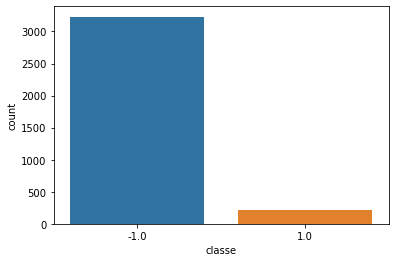

Análise das matrizes de covariância 


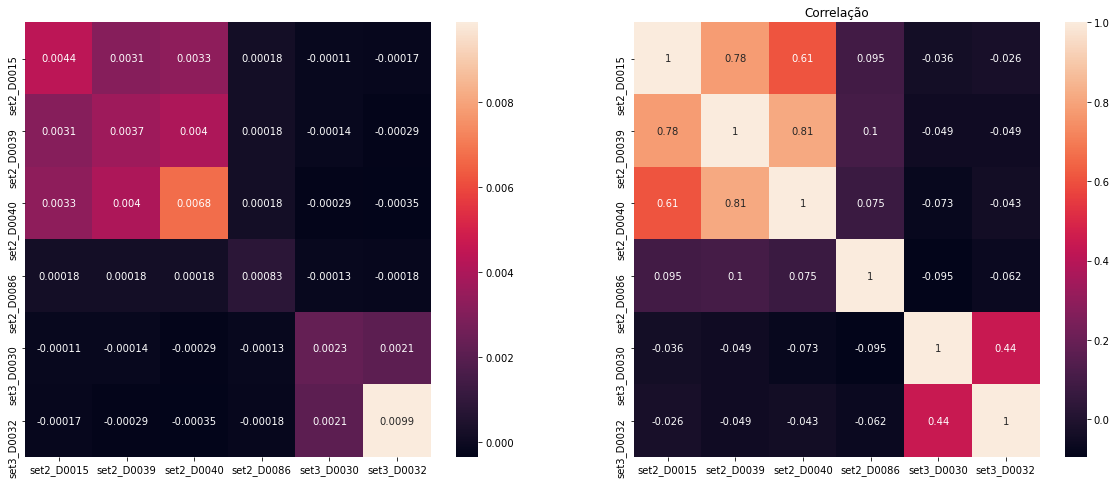

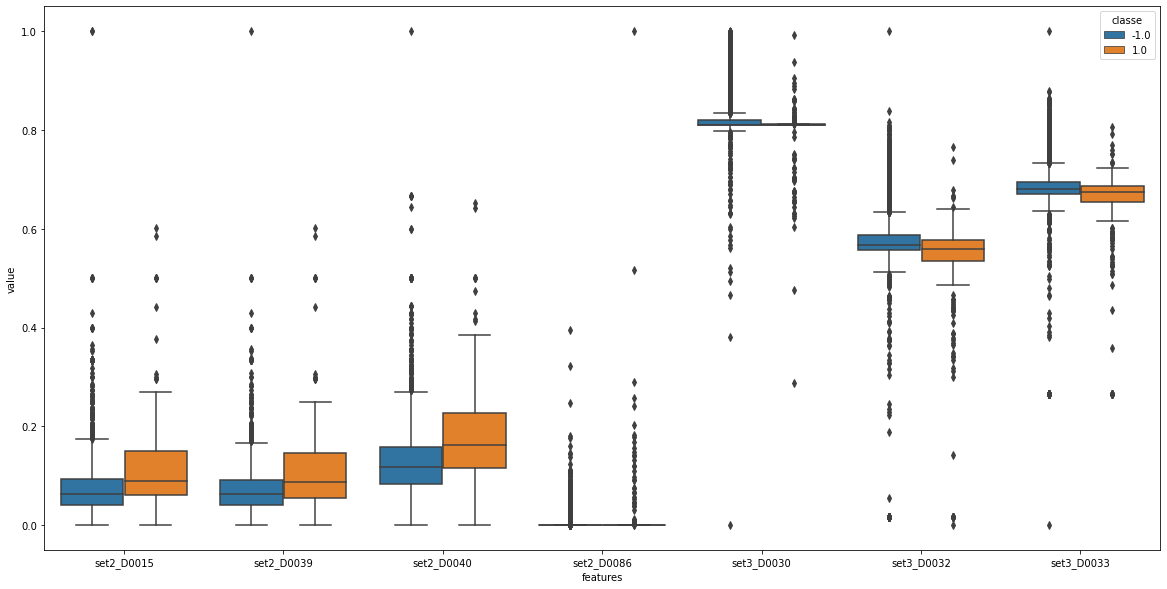

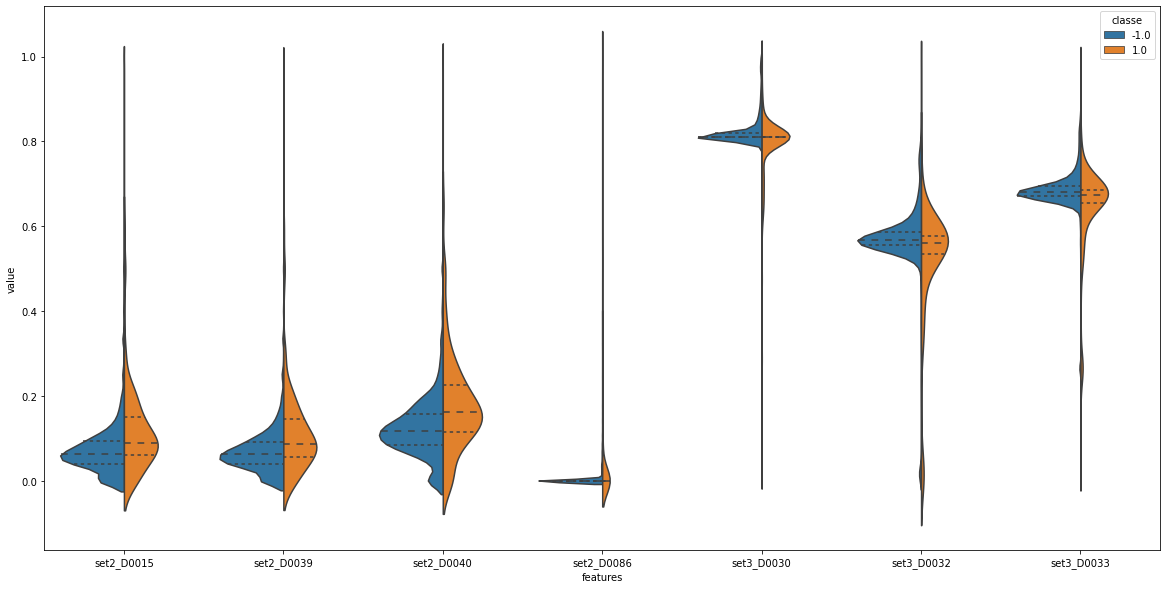

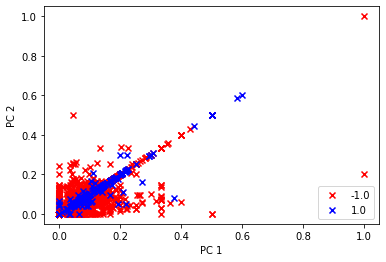

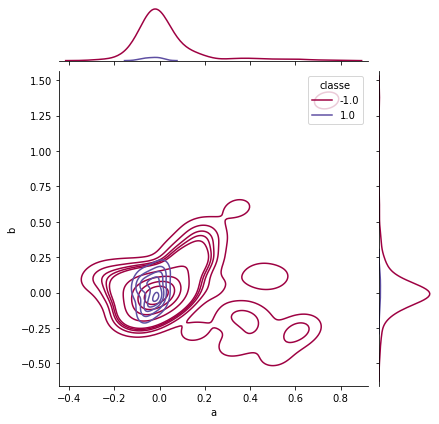

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
from scripts import analise_exploratoria

# Análise do balanceamento das classes
print('Análise e visualização dos dados:')
ax = sns.countplot(x='classe', data=pd.concat([X_train_df,y_train_df], axis=1), label="Contagem")

N,P = y_train_df.classe.value_counts()
print('Número de posts comuns:', N)
print('Número de posts phishing:', P)
plt.show()

# Análise da matriz scatter pra que entendamos a relação entre os atributos
#print('Análise da matriz de dispersão')
#sns.pairplot(input_dataset.loc[(input_dataset['classe'] == -1) | (input_dataset['classe'] == 1)], hue='classe', height=3.5);
#plt.show()

# matrizes de covariancia e correlação
print('Análise das matrizes de covariância ')
df_covariance = X_train_df.iloc[:,:-1].cov()
df_correlation = X_train_df.iloc[:,:-1].corr()
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 8))
plt.title('Covariância')
sns.heatmap(df_covariance, annot=True, xticklabels=df_correlation.columns, 
            yticklabels=df_correlation.columns, ax=ax1)
plt.title('Correlação')
sns.heatmap(df_correlation, annot=True, xticklabels=df_correlation.columns, 
            yticklabels=df_correlation.columns, ax=ax2)
plt.show()

# Montagem do dataset de teste para envio para o Kaggle
K = input_dataset.loc[test_dataset.iloc[:,:].values.T[0]]
K = K.drop('classe', axis=1).values

# Diagramas de caixa
plt.figure(figsize=(20,10))
data = pd.melt(pd.concat([X_train_df,y_train_df], axis=1),
               id_vars="classe", var_name="features", value_name='value')
sns.boxplot(x='features', y='value', hue='classe', data=data)
plt.show()

# Diagramas de violino
plt.figure(figsize=(20,10))
sns.violinplot(x='features', y='value', hue='classe', data=data, split=True, inner="quartile")
plt.show()

# Separação de atributos e classe para 
analise_exploratoria.printPCA(X_train_df.values,y_train_df.values.T[0])    

analise_exploratoria.printJointPlot(X_train_df,y_train_df)    

utils.beep(1, 600)   

---
### Preparo dos dados e experimentos para encontrar os melhores hiperparâmetros

Nesta seção os dados são separados em duas partes: treino e testes. Esta estratégia foi utilizada para posterior comparação com a validação de modelos utilizandos K-folds.
Para encontrar os melhores hiperparâmetros foi utilizada a classe GridSearchCV e devido o seu alto custo computacional e não existência da necessidade de executá-las sempre, a sua chamada é condicionada às variáveis booleanas evaluate_svm_hiperparameters, evaluate_rfc_hiperparameters e evaluate_lrc_hiperparameters serem verdadeiras.

In [4]:

from scripts import preprocessamento
from scripts import experimentos
from scripts import utils

X_train = X_train_df.values
y_train = y_train_df.values.T[0]
X_test = X_test_df.values
y_test = y_test_df.values.T[0]

# Utilize as flags abaixo somente para avaliação dos hiperparâmetros pois elas demoram muito pra serem executadas
evaluate_svm_hiperparameters = False # Busca os melhores parâmetros para as máquinas de vetores de suporte
evaluate_rfc_hiperparameters = False # Busca os melhores parâmetros para as florestas aleatórias
evaluate_knn_hiperparameters = False # Busca os melhores parâmetros para o KNN

print('Removendo amostras outliers')
X, y = preprocessamento.remove_outliers(X_train, y_train)



scores = ['balanced_accuracy', 'f1', 'roc_auc']

if evaluate_svm_hiperparameters == True:
    experimentos.find_best_svm(X,y, scores)
    
if evaluate_rfc_hiperparameters == True:    
    experimentos.find_best_rfc(X, y, scores)
        
if evaluate_knn_hiperparameters == True:
    experimentos.find_best_knn(X, y, scores)

utils.beep(1, 700)

Removendo amostras outliers
Amostras positivas (phishing) mantidas: 193 de 218
Percentual de outliers removidos: 11.5%
Amostras negativas (HAM) mantidas: 2895 de 3230
Percentual de outliers removidos: 10.4%


---
### Experimento

Nesta seção, o experimento deve ser conduzido, utilizando os protocolos experimentais ensinados no curso e executando os métodos inteligentes

In [5]:
# Importa os classificadores usados nesse trabalho
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn import svm

from scripts import experimentos
from scripts import preprocessamento



clf1 = svm.SVC(kernel='poly', class_weight='balanced', decision_function_shape='ovr', probability=True,random_state=1)
clf2 =  KNeighborsClassifier(n_neighbors=1, leaf_size=4, weights='distance')
clf3 = svm.SVC(kernel='rbf', C=400, gamma='scale', class_weight='balanced', decision_function_shape='ovr', probability=True,random_state=1)


collect_more_samples = False
collect_more_samples_again = False

X_train_bal, y_train_bal = X, y

scoring=['roc_auc', 'f1', 'f1_micro', 'f1_macro', 'f1_weighted', 'accuracy', 'balanced_accuracy', 'precision', 'recall']

results = pd.DataFrame()

model_list = [
    ['SVM poly', svm.SVC(kernel='poly', class_weight='balanced', decision_function_shape='ovr', probability=True,random_state=1), 0],
   # ['SVM linear', svm.SVC(kernel='linear', C=100, class_weight='balanced', decision_function_shape='ovr', probability=True,random_state=1), 0],
   # ['SVM rbf', svm.SVC(kernel='rbf', C=1000, gamma=0.0001, class_weight='balanced', decision_function_shape='ovr', probability=True,random_state=1), 0],
   # ['SVM rbf RA', svm.SVC(kernel='rbf', C=10, gamma='scale', class_weight='balanced', decision_function_shape='ovr', probability=True,random_state=1), 0],
   # ['SVM rbf BA', svm.SVC(kernel='rbf', C=400, gamma='scale', class_weight='balanced', decision_function_shape='ovr', probability=True,random_state=1), 0],
   # ['SVM rbf F1', svm.SVC(kernel='rbf', C=600, gamma=0.001, class_weight='balanced', decision_function_shape='ovr', probability=True,random_state=1), 0],
   # ['Random Forest', RandomForestClassifier(max_depth=2, class_weight='balanced', random_state=1), 0],
   # ['Logistic Regression', LogisticRegression(random_state=1, class_weight='balanced', max_iter=15000), 0],
   # ['Multinomial NB', MultinomialNB(), 0],
   # ['MLP', MLPClassifier( alpha=1e-5, hidden_layer_sizes=(600,), random_state=1, max_iter=5000, ), 0],
    ['KNN', KNeighborsClassifier(n_neighbors=1, leaf_size=4, weights='distance'), 0],
   # ['KNN 8', KNeighborsClassifier(n_neighbors=8, leaf_size=4, weights='distance'), 0],
   # ['KNN 70', KNeighborsClassifier(n_neighbors=70, leaf_size=1, weights='distance'), 0],
    ['AdaBoost', AdaBoostClassifier(n_estimators=100, random_state=0), 0],
    ['GradBoost', GradientBoostingClassifier(random_state=0), 0],
    ['Voting', VotingClassifier(estimators=[('svm', clf1), ('mlp', clf2), ('rf', clf3)], voting='soft')]
]

# Pré balanceamento dos dados utilizando a técnica de oversampling
X_train_bal, y_train_bal = preprocessamento.oversample(X_train_bal, y_train_bal, times=1)
X_bal, y_bal = preprocessamento.oversample(X, y, times=1)

semi_model = svm.SVC(kernel='poly', class_weight='balanced', decision_function_shape='ovr', probability=True,random_state=1)
# População dos dados não classificados com o melhor classificador encontrado com os resultados mais confiáveis
if collect_more_samples == True:
    X_semi, y_semi, proba_mask = preprocessamento.add_samples(semi_model, X_bal, y_bal, samples_df.values)

    print('Número de amostras acrescentadas ao dataset de treinamento:', X_semi.shape[0], 
                                                                          np.sum(y_semi==-1), np.sum(y_semi==1))
    
    pos_mask = y_semi==1
    X_semi_positives = X_semi[pos_mask]
    y_semi_positives = y_semi[pos_mask]
    
    X_semi_positives = X_semi_positives
    y_semi_positives = y_semi_positives
    
    X_train_bal = np.concatenate([X_train_bal, X_semi_positives], axis=0)
    y_train_bal = np.concatenate([y_train_bal, y_semi_positives], axis=0)
    X_bal = np.concatenate([X_bal, X_semi_positives], axis=0)
    y_bal = np.concatenate([y_bal, y_semi_positives], axis=0)

if collect_more_samples_again == True:
    X_train_bal, y_train_bal = preprocessamento.oversample(X_train_bal, y_train_bal)
    X_bal, y_bal = preprocessamento.oversample(X_bal, y_bal)

    # População dos dados não classificados com o melhor classificador encontrado com os resultados mais confiáveis
    samples = samples[~proba_mask]
    X_semi, y_semi, proba_mask = preprocessamento.add_samples(semi_model, X_train_bal, y_train_bal, samples)
    print('Número de amostras acrescentadas ao dataset de treinamento:', X_semi.shape[0], 
                                                                          np.sum(y_semi==-1), np.sum(y_semi==1))
    X_train_bal = np.concatenate([X_train_bal, X_semi], axis=0)
    y_train_bal = np.concatenate([y_train_bal, y_semi], axis=0)
    X_bal = np.concatenate([X_bal, X_semi], axis=0)
    y_bal = np.concatenate([y_bal, y_semi], axis=0)

print(X_bal.shape, X_train_bal.shape, np.sum(y_bal==-1),np.sum(y_bal==1), np.sum(y_train_bal==-1),np.sum(y_train_bal==1))
#X_train_bal, y_train_bal = preprocessamento.oversample(X_train_bal, y_train_bal)
#X_bal, y_bal = preprocessamento.oversample(X_bal, y_bal)

for model in model_list:
    print(model[0] + '------------------------------------------------------------------------------------')
    scores = experimentos.evaluate_model(model[1], X_train_bal, y_train_bal, X_test, y_test)

    for score in scores:
        results.loc[model[0], score] = np.mean(scores[score])
    


utils.beep(1, 800)

Balaceamento antes da SOBREamostragem 2895 193
Balaceamento após da SOBREamostragem 2895 193
Balaceamento antes da SOBREamostragem 2895 193
Balaceamento após da SOBREamostragem 2895 193
(3088, 7) (3088, 7) 2895 193 2895 193
SVM poly------------------------------------------------------------------------------------
KNN------------------------------------------------------------------------------------
AdaBoost------------------------------------------------------------------------------------
GradBoost------------------------------------------------------------------------------------
Voting------------------------------------------------------------------------------------


---
### Análise dos Resultados

Nesta seção, os resultados devem ser exibidos e comparados, através de tabelas e gráficos

,bal_acc_train,bal_acc_test,f1_weighted,f1_micro,precision,recall,mcc,roc_auc,TP,TN,train_time,predict_time
SVM poly,0.6779,0.6270,0.8652,0.8353,0.1615,0.3889,0.1720,0.6867,699.0000,21.0000,0.8044,0.0211
KNN,0.9862,0.5814,0.8887,0.8794,0.1711,0.2407,0.1391,0.5814,745.0000,13.0000,0.0028,0.0054
AdaBoost,0.6370,0.5925,0.8923,0.8840,0.1892,0.2593,0.1600,0.6714,748.0000,14.0000,0.2971,0.0175
GradBoost,0.7563,0.5734,0.9074,0.9130,0.2439,0.1852,0.1672,0.6689,777.0000,10.0000,0.4617,0.0011
Voting,0.6010,0.5660,0.8986,0.8991,0.1887,0.1852,0.1331,0.6575,765.0000,10.0000,2.5568,0.0613


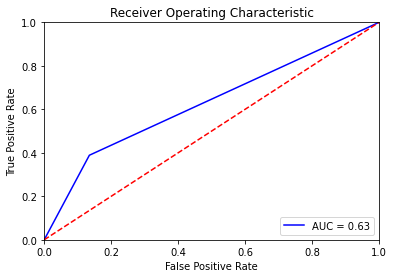

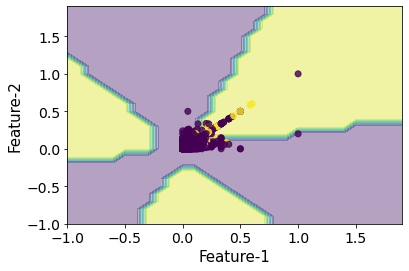

In [6]:
from scripts import analise_resultados

submit_preference_score = 'SVM poly'

for model in model_list:
    if model[0]==submit_preference_score:
        best_model = model[1]


def highlight_max(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.max()
    
    return ['background-color: yellow' if v else '' for v in is_max]

pd.set_option('precision', 4)
results_highlited = results.style.apply(highlight_max)
display(results_highlited)

y_pred = best_model.predict(X_test)
analise_resultados.print_rocauc_curve(y_test, y_pred)
analise_resultados.plot_decision_boundaries(X_train, y_train, svm.SVC, kernel='poly', class_weight='balanced', decision_function_shape='ovr', probability=True,random_state=1)


utils.beep(3, 1000)

---
### Criação do arquivo de sumissão no Kaggle

Na etapa final, o arquivo submission.csv é criado para ser enviado ao Kaggle de acordo com os padrões pré-definidos pela proposta do desafio.

In [ ]:
submit_preference_score = 'SVM poly'

for model in model_list:
    if model[0]==submit_preference_score:
        best_model = model[1]

print('Criando arquivo de submissão para o modelo: ' + submit_preference_score)    
    
print('Imprimindo arquivo submission.csv ...')
clf= best_model.fit(X_bal, y_bal)
y_pred_submission = clf.predict_proba(K)[:,1]
result = np.zeros((K.shape[0],2))
for i in range(K.shape[0]):
    result[i][0] = test_dataset.iloc[:,:].values.T[0][i]
    result[i][1] = y_pred_submission[i]
resultdf = pd.DataFrame(data=result, columns=["Id", "Predicted"])
resultdf['Id'] = resultdf['Id'].astype(int)
resultdf['Predicted'] = resultdf['Predicted'].round(decimals=5)
resultdf.to_csv('submission.csv', index=False, float_format='%.5f')
print('####################################################################################################')

utils.beep(5, 200)

Criando arquivo de submissão para o modelo: SVM poly
Imprimindo arquivo submission.csv ...
